Select action type:
1. Batting
2. Bowling
3. Throwing
4. Fielding
5. Wicket Keeping
6. Gym Exercise
Select gym exercise type:
1. Push
2. Pull
3. Hinge
4. Squat
5. Lunge
6. Explosive / Plyometric
7. Mobility / Flexibility
Analyzing: pull


I0000 00:00:1759042928.681174  268506 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M1
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1759042928.893147  272212 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1759042928.929990  272214 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1759042928.966893  272209 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


Joint angles saved to ./outputs/joint_angles_pull.csv
Processed video saved to ./outputs/processed_pull.mp4


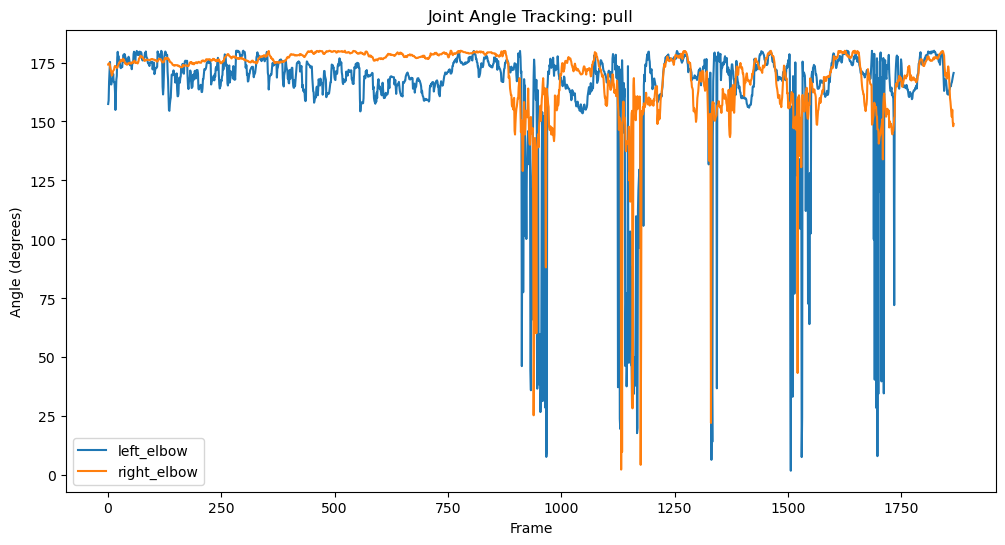

In [1]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- Initialize MediaPipe Pose ---
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

# --- Helper function to calculate joint angle ---
def calculate_angle(a, b, c):
    a, b, c = np.array(a), np.array(b), np.array(c)
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.degrees(np.arccos(np.clip(cosine_angle, -1.0, 1.0)))
    return angle

# --- Function to get relevant joints based on action ---
def get_joints_for_action(action):
    joints = {}
    if action.lower() == "batting":
        joints = {
            "left_elbow": ["LEFT_SHOULDER","LEFT_ELBOW","LEFT_WRIST"],
            "right_elbow": ["RIGHT_SHOULDER","RIGHT_ELBOW","RIGHT_WRIST"],
            "left_knee": ["LEFT_HIP","LEFT_KNEE","LEFT_ANKLE"],
            "right_knee": ["RIGHT_HIP","RIGHT_KNEE","RIGHT_ANKLE"]
        }
    elif action.lower() == "bowling":
        joints = {
            "left_elbow": ["LEFT_SHOULDER","LEFT_ELBOW","LEFT_WRIST"],
            "right_elbow": ["RIGHT_SHOULDER","RIGHT_ELBOW","RIGHT_WRIST"],
            "left_knee": ["LEFT_HIP","LEFT_KNEE","LEFT_ANKLE"],
            "right_knee": ["RIGHT_HIP","RIGHT_KNEE","RIGHT_ANKLE"],
            "trunk": ["LEFT_SHOULDER","RIGHT_SHOULDER","LEFT_HIP","RIGHT_HIP"]
        }
    elif action.lower() == "throwing":
        joints = {
            "left_elbow": ["LEFT_SHOULDER","LEFT_ELBOW","LEFT_WRIST"],
            "right_elbow": ["RIGHT_SHOULDER","RIGHT_ELBOW","RIGHT_WRIST"],
            "trunk": ["LEFT_SHOULDER","RIGHT_SHOULDER","LEFT_HIP","RIGHT_HIP"]
        }
    elif action.lower() == "fielding":
        joints = {
            "left_knee": ["LEFT_HIP","LEFT_KNEE","LEFT_ANKLE"],
            "right_knee": ["RIGHT_HIP","RIGHT_KNEE","RIGHT_ANKLE"]
        }
    elif action.lower() == "wicket keeping":
        joints = {
            "left_knee": ["LEFT_HIP","LEFT_KNEE","LEFT_ANKLE"],
            "right_knee": ["RIGHT_HIP","RIGHT_KNEE","RIGHT_ANKLE"],
            "trunk": ["LEFT_SHOULDER","RIGHT_SHOULDER","LEFT_HIP","RIGHT_HIP"]
        }
    elif action.lower() in ["push","pull","hinge","squat","lunge","explosive","mobility"]:
        # Generic gym movement
        if action.lower() in ["push"]:
            joints = {
                "left_elbow": ["LEFT_SHOULDER","LEFT_ELBOW","LEFT_WRIST"],
                "right_elbow": ["RIGHT_SHOULDER","RIGHT_ELBOW","RIGHT_WRIST"]
            }
        elif action.lower() in ["pull"]:
            joints = {
                "left_elbow": ["LEFT_SHOULDER","LEFT_ELBOW","LEFT_WRIST"],
                "right_elbow": ["RIGHT_SHOULDER","RIGHT_ELBOW","RIGHT_WRIST"]
            }
        elif action.lower() in ["hinge"]:
            joints = {
                "left_knee": ["LEFT_HIP","LEFT_KNEE","LEFT_ANKLE"],
                "right_knee": ["RIGHT_HIP","RIGHT_KNEE","RIGHT_ANKLE"],
                "trunk": ["LEFT_SHOULDER","RIGHT_SHOULDER","LEFT_HIP","RIGHT_HIP"]
            }
        elif action.lower() in ["squat","lunge"]:
            joints = {
                "left_knee": ["LEFT_HIP","LEFT_KNEE","LEFT_ANKLE"],
                "right_knee": ["RIGHT_HIP","RIGHT_KNEE","RIGHT_ANKLE"],
                "trunk": ["LEFT_SHOULDER","RIGHT_SHOULDER","LEFT_HIP","RIGHT_HIP"]
            }
        elif action.lower() in ["explosive","mobility"]:
            joints = {
                "left_elbow": ["LEFT_SHOULDER","LEFT_ELBOW","LEFT_WRIST"],
                "right_elbow": ["RIGHT_SHOULDER","RIGHT_ELBOW","RIGHT_WRIST"],
                "left_knee": ["LEFT_HIP","LEFT_KNEE","LEFT_ANKLE"],
                "right_knee": ["RIGHT_HIP","RIGHT_KNEE","RIGHT_ANKLE"],
                "trunk": ["LEFT_SHOULDER","RIGHT_SHOULDER","LEFT_HIP","RIGHT_HIP"]
            }
    return joints

# --- Prompt user ---
print("Select action type:")
print("1. Batting")
print("2. Bowling")
print("3. Throwing")
print("4. Fielding")
print("5. Wicket Keeping")
print("6. Gym Exercise")
action_input = input("Enter action name or number: ").strip()

if action_input == "6" or action_input.lower() == "gym exercise":
    print("Select gym exercise type:")
    print("1. Push")
    print("2. Pull")
    print("3. Hinge")
    print("4. Squat")
    print("5. Lunge")
    print("6. Explosive / Plyometric")
    print("7. Mobility / Flexibility")
    gym_input = input("Enter gym exercise name or number: ").strip()
    gym_map = {
        "1":"push","2":"pull","3":"hinge","4":"squat","5":"lunge","6":"explosive","7":"mobility"
    }
    action = gym_map.get(gym_input,gym_input.lower())
else:
    action_map = {
        "1":"batting","2":"bowling","3":"throwing","4":"fielding","5":"wicket keeping"
    }
    action = action_map.get(action_input,action_input.lower())

print(f"Analyzing: {action}")

# --- Paths ---
input_video_path = "./inputs/IMG_8099.mov"
output_video_path = f"./outputs/processed_{action}.mp4"
csv_output_path = f"./outputs/joint_angles_{action}.csv"

# --- Video Capture & Writer ---
cap = cv2.VideoCapture(input_video_path)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

# --- Pose Detection ---
pose = mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5)
joint_angles = {"frame": []}
joints_to_track = get_joints_for_action(action)
# Initialize keys in dict
for joint_name in joints_to_track.keys():
    joint_angles[joint_name] = []

frame_count = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose.process(image)

    if results.pose_landmarks:
        lm = results.pose_landmarks.landmark
        h, w, _ = frame.shape

        def get_coords(idx_name):
            idx = mp_pose.PoseLandmark[idx_name].value
            return (int(lm[idx].x * w), int(lm[idx].y * h))

        # Compute angles
        for joint_name, points in joints_to_track.items():
            if joint_name != "trunk":
                a = get_coords(points[0])
                b = get_coords(points[1])
                c = get_coords(points[2])
                angle = calculate_angle(a,b,c)
                joint_angles[joint_name].append(angle)
                # Overlay angle
                cv2.putText(frame, f"{joint_name}: {int(angle)}°", (b[0]+10,b[1]-10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)
            else:
                # Optional: compute trunk tilt angle
                left_shoulder = get_coords(points[0])
                right_shoulder = get_coords(points[1])
                left_hip = get_coords(points[2])
                right_hip = get_coords(points[3])
                # Simple trunk tilt = angle between shoulders and hips line vs horizontal
                shoulder_mid = ((left_shoulder[0]+right_shoulder[0])//2, (left_shoulder[1]+right_shoulder[1])//2)
                hip_mid = ((left_hip[0]+right_hip[0])//2, (left_hip[1]+right_hip[1])//2)
                dx = shoulder_mid[0]-hip_mid[0]
                dy = shoulder_mid[1]-hip_mid[1]
                trunk_angle = np.degrees(np.arctan2(dy,dx))
                joint_angles[joint_name].append(trunk_angle)
                cv2.putText(frame, f"{joint_name}: {int(trunk_angle)}°", (hip_mid[0]+10, hip_mid[1]-10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,255), 2)

        joint_angles["frame"].append(frame_count)

        # Draw pose
        mp_drawing.draw_landmarks(frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

    # Write frame to video
    out.write(frame)
    cv2.imshow("Pose Tracking", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
out.release()
cv2.destroyAllWindows()

# --- Save CSV ---
df = pd.DataFrame(joint_angles)
df.to_csv(csv_output_path,index=False)
print(f"Joint angles saved to {csv_output_path}")
print(f"Processed video saved to {output_video_path}")

# --- Plot angles ---
plt.figure(figsize=(12,6))
for joint_name in joints_to_track.keys():
    plt.plot(joint_angles["frame"], joint_angles[joint_name], label=joint_name)
plt.xlabel("Frame")
plt.ylabel("Angle (degrees)")
plt.legend()
plt.title(f"Joint Angle Tracking: {action}")
plt.show()
